In [ ]:
#pip install mesa

In [ ]:
import mesa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from mesa.visualization.modules import CanvasGrid, ChartModule
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import TextElement
from mesa.datacollection import DataCollector
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import logging

In [ ]:
#global seed
# Set a global seed
global_seed = 100
random.seed(global_seed)
np.random.seed(global_seed)

In [ ]:
class AgentCountElement(TextElement):
    def __init__(self):
        pass

    def render(self, model):
        agents_count = model.schedule.get_type_count(Non_corrupt_agent)
        sugar_agents_count = model.schedule.get_type_count(Sugar)
        return f"Non Corrupt Agents: {agents_count} | Sugar Agents: {sugar_agents_count}"

class AverageWealthElement(TextElement):
    def render(self, model):
        # Calculate the average wealth of alive corrupt agents
        agents = [agent for agent in model.schedule.agents_by_type[Non_corrupt_agent].values()]
        if agents:
            average_wealth = sum(agent.sugar_agent for agent in agents) / len(agents)
        else:
            average_wealth = 0
        return f"Average Wealth of Agents: {average_wealth:.2f}"

In [ ]:
# Helper functions

# Calculate the Euclidean distance between cells
def distance(dist1, dist2):
    x1, y1 = dist1
    x2, y2 = dist2
    dist_x = x1 - x2
    dist_y = y1 - y2

    dist = math.sqrt((dist_x ** 2) + (dist_y ** 2))
    return dist

#For logging
logging.basicConfig(filename='/content/sample_data/corrupt.log',
                    level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s',
                    force=True)

In [ ]:
#This is a class for sugar patches. Each sugar patch is treated as an agent
class Sugar(mesa.Agent):
    def __init__(self, unique_id, model, position, sugar_capacity):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patche in the grid
        self.curr_amount = sugar_capacity #the current amount of sugar in a patch. Can be reduced if an agent eats the sugar
        self.sugar_capacity = sugar_capacity #maximum sugar for a patch
        self.step_counter = 0  # Counter for steps

    #The step function is going to add one unit of sugar per step until sugar is at its maximum capacity
    def step(self):
        #self.step_counter += 1
        #if self.step_counter % 2 == 0:
        self.curr_amount = min([self.sugar_capacity, self.curr_amount + 1])
        #self.curr_amount = min([self.sugar_capacity, 10])
        #print(self.unique_id, self.curr_amount, self.sugar_capacity)

In [ ]:
#Class for corrupt agents
class Non_corrupt_agent(mesa.Agent):
    def __init__(self, unique_id, model, position, moore = False, sugar_agent = 0, sugar_metabolism = 0, sugar_vision = 0):
        super().__init__(unique_id, model)
        self.position = position #position of sugar patch in the grid
        self.moore = moore
        self.sugar_agent = sugar_agent
        self.sugar_metabolism = sugar_metabolism
        self.sugar_vision = sugar_vision
        self.shared_with_count = 0  # Counter for tracking sharing actions
        self.share_amount = 0
        self.steal_amount = 0
        self.share_total = 0
        self.eat_total = 0
        self.moved = False
        self.dead = False
        self.survival = 0
        self.action_count = {}

    #determines if the neigbouring cell is a sugar patch
    def is_sugar(self, position):
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for agent in cell:
            if type(agent) is Sugar: # referes to the sugar class
                return agent
            return None

    # Get Sugar amount in the next cell
    def sugar_amount(self, position):
        sugar = self.is_sugar(position)
        if sugar:
            return sugar.curr_amount
        return 0

    def get_neighbours(self, position):
        '''
        This is a helper function for share_with_neighbours()
        '''
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position

        for agent in cell:
            if isinstance(agent, Non_corrupt_agent): #if cell has corrupt agent
                return agent

    def neighbour_wellbeing(self, position):
        """This function returns the wealth of neighbours"""
        neighbour = [agent for agent in self.model.grid.get_neighbors(self.position, self.moore, False, self.sugar_vision)
                 if isinstance(agent, Non_corrupt_agent)]

        for i in neighbour:
            return i.sugar_agent
        return 0

    # the following function helps move() to determine if a cell has been occupied
    def cell_occupied(self, position):
        if position == self.position: # Agents are allowed to stay in the same position
           return False #not occupied
        # Now we cater for a situation in which a cell is occupied
        cell = self.model.grid.get_cell_list_contents(position) # Gets the contents of a cell in a given position
        for j in cell: #going through all neihgbourhoot cells
            if isinstance(j, Non_corrupt_agent): #if cell has corrupt agent
                return True
        return False

    # This function calculates welfares non corrupt_agents
    def calculate_welfare(self, sugar):
        welfare = sugar/self.sugar_metabolism + 0.0000001
        return welfare

    # This function calculates needs of non corrupt_agents
    def calculate_need(self):
        need = self.sugar_agent/self.sugar_metabolism + 0.000001
        return need

    # This function etermines whether an agent is starved or not
    def starved(self):
        return (self.sugar_agent <= 0)

    def fair_share(self, other, amount):
        need_self = self.calculate_need()
        need_other = other.calculate_need()

        # Share if the other agent's need is greater and the difference in wealth is reasonable
        if need_other > need_self:
            #share_amount = self.sugar_agent // 4  # Share half the difference
            share_amount = amount
            self.sugar_agent -= share_amount
            other.sugar_agent += share_amount
            self.shared_with_count += 1
            self.share_total += share_amount
            #print(f"Agent {self.unique_id} has shared a total of {self.share_total}")
            logging.info(f"Agent {other.unique_id} with {need_other} has received {share_amount} from {self.unique_id} with {self.sugar_agent}")
        else:
            # Do nothing if sharing would be unfair or unnecessary
            pass

    # This function moves agents in the grid
    def move(self, exploration_prob=0.1):
        '''
        #1 Identify possible moves
        #2 Determine move that maximizes welfare
        #3 Find closest best option
        #4 Move
        '''

        #1 Identifying possible moves
        neighborhood = [i
                        for i in self.model.grid.get_neighborhood(self.position, self.moore, True, self.sugar_vision)
                        if not self.cell_occupied(i)  # Ensure that multiple corrupt agents are not in the same cell
                        ]

        # If the neighborhood is empty, return early
        if not neighborhood:
            return

        #2 Randomly decide whether to explore
        if self.random.random() < exploration_prob:
            # Exploration: Choose a random position from the neighborhood
            cell_final = [self.random.choice(neighborhood)]
        else:
            #3 Determine which neighbors provide maximum welfare
            welfare = [self.calculate_welfare(self.sugar_agent + self.sugar_amount(position)) for position in neighborhood]
            max_welfare = max(welfare)

            # Index of max welfare cells
            cell_indices = [i for i in range(len(welfare))
                            if math.isclose(welfare[i], max_welfare, rel_tol=1e-02)
                            ]

            # Converting indexes to cell positions
            cell_position = [neighborhood[i] for i in cell_indices]

            # Find the closest best option
            shortest_dist = min(distance(self.position, position) for position in cell_position)
            cell_final = [pos for pos in cell_position
                          if math.isclose(distance(self.pos, pos), shortest_dist, rel_tol=1e-02)
                          ]

        # If no valid move is found (e.g., all welfare values are equal), explore randomly
        if not cell_final or cell_final[0] == self.position:
            # Choose a random position from the neighborhood to ensure the agent moves
            cell_final = [self.random.choice(neighborhood)]

        self.random.shuffle(cell_final)  # Randomize choice if multiple equal options

        if cell_final[0] != self.position:
            self.moved = True

        #4 Move agent
        self.model.grid.move_agent(self, cell_final[0])

    # This function is for agents to consume resources
    def eat(self, amount):
        sugar_patch = self.is_sugar(self.position)
        if sugar_patch:
            amnt = min([sugar_patch.curr_amount, amount])
            self.sugar_agent += amnt
            self.eat_total += amnt
            logging.info(f"Agent {self.unique_id} has eaten {amnt} sugar from sugar {sugar_patch.unique_id}")
            sugar_patch.curr_amount -= amnt
            action_str = f"eat({amount})"
            self.action_count[action_str] = self.action_count.get(action_str, 0) + 1

    def metabolize(self):
        self.sugar_agent -= self.sugar_metabolism


    # This function kills off agents who have usedup all their sugar
    def agent_die(self):
        if self.dead == False:
                self.survival+=1
        if self.starved():
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
            self.model.grid.remove_agent(self)
            self.model.schedule.remove(self)
            self.model.dead_agents += 1  # Increment the dead agents counter in the model
            self.dead = True
            #print(self.unique_id, self.sugar_agent, self.model.schedule.get_type_count(Corrupt_agent))
        #elif not self.starved():
        #    print(self.unique_id, self.sugar_agent, self.sugar_vision, self.model.schedule.get_type_count(Corrupt_agent))

    #this is the function that corrupt agents will use to share resources
    def share_with_neighbours(self, amount):
        '''
        This will be in three parts:
        1. Identify neighbours to share with
        2. Share with those
        3. Collect data
        '''

        #Neighbors below help us create a list of agents we can share with
        ##get_neighbours() is ahelper function
        neighbors = [self.get_neighbours(position) for position in self.model.grid.get_neighborhood(self.position, self.moore, False, self.sugar_vision)
                    if self.cell_occupied(position)
                   ]

        if len(neighbors) == 0:
            return [],[] #return 2 empty lists if an agent doesn't have neighbors

        #iterate through neighbours and share
        for i in neighbors:
            if i:
                self.fair_share(i, amount)
                action_str = f"share({amount})"
                self.action_count[action_str] = self.action_count.get(action_str, 0) + 1

    def get_state(self):
        return [
            self.position[0],
            self.position[1],
            self.sugar_vision,
            self.sugar_metabolism,
            self.neighbour_wellbeing(self.position)
          ]


DQN Stuff

In [ ]:
#Newural Network
class DQN(nn.Module):
    def __init__(self, state_size, action_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(state_size, 10)
        self.layer2 = nn.Linear(10, 10)
        self.layer3 = nn.Linear(10, action_size)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, experience):
        self.memory.append(experience)

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)


In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.9
        self.learning_rate = 0.09
        self.loss_fn = nn.SmoothL1Loss()

        #Initializing the models
        self.model = DQN(state_size, action_size)
        self.target_model = DQN(state_size, action_size)

        # Copy initial weights from the main model to the target model
        self.update_target_model()

        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)# Using the adam optimizer

    def update_target_model(self):
        # This function copies weights from main to target model
        self.target_model.load_state_dict(self.model.state_dict())

    def save_weights(self, filepath):
        # Save the weights of the trained model
        torch.save(self.model.state_dict(), filepath)

    def load_weights(self, filepath):
          # Load the saved weights into the model
          self.model.load_state_dict(torch.load(filepath))
          self.update_target_model()  # Update target model as well

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)  # Random action (exploration)
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.model(state)
        return torch.argmax(act_values).item()  # Choose the action with the highest Q-value

    def replay(self, batch_size):
        if len(self.memory) < batch_size:
            return
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            reward = torch.FloatTensor([reward])
            action = torch.LongTensor([action])

            if not done:
                target = reward + self.gamma * torch.max(self.target_model(next_state)).item() #Computing target Q-Values
            else:
                target = reward

            current_q = self.model(state)[0][action] #Computing currnt Q-Value
            loss = self.loss_fn(current_q, target)

            # BAckprobagation
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay


In [ ]:
dqn_agent = DQNAgent(state_size=5, action_size=10)

In [ ]:
#This class belongs to the main model, the engine of the project.
class Model(mesa.Model):
    def __init__(self, X = 50, Y = 50, init_population = 100, init_resource_min = 10, init_resource_max = 20, metabolism_min = 1, metabolism_max = 5, vision_min = 1, vision_max = 5, seed=None):
        #grid-space width and height
        self.X = X
        self.Y = Y

        # Set the global seed if provided
        if seed is not None:
            self.seed = seed
            random.seed(self.seed)
            np.random.seed(self.seed)

        #initializing population attributes
        self.init_population = init_population
        self.init_resource_min = init_resource_min
        self.init_resource_max = init_resource_max
        self.metabolism_min = metabolism_min
        self.metabolism_max = metabolism_max
        self.vision_min = vision_min
        self.vision_max = vision_max
        self.running = True
        self.dead_agents = 0
        self.cycle = 0
        self.total_eaten = {4: 0, 4.2: 0, 4.4: 0, 4.6: 0, 4.8: 0}
        self.total_shared = {0: 0, 0.2: 0, 0.4: 0, 0.6: 0, 0.8: 0}

        #initiate mesa grid
        self.grid = mesa.space.MultiGrid(self.X, self.Y, torus = False)
        self.schedule = mesa.time.RandomActivationByType(self) #randomizes the sequence in which agents perform actions
        sugar_distro = np.genfromtxt("/content/sample_data/random.txt")
        #plt.imshow(sugar_distro, origin = "lower") #Shows the grid

        # Initialize the DataCollector
        self.datacollector = mesa.DataCollector(
            model_reporters = {
                "Step": lambda model: model.schedule.steps,
                "Agents": lambda model: model.schedule.get_type_count(Non_corrupt_agent),
                "Average Wealth": lambda model: model.avg_wealth()
            },

            agent_reporters = {
                "Unique ID": lambda agent: agent.unique_id if isinstance(agent, Non_corrupt_agent) else 0,
                "Wealth": lambda agent: agent.sugar_agent if isinstance(agent, Non_corrupt_agent) else 0,
                "Survival": lambda agent: agent.survival if isinstance(agent, Non_corrupt_agent) else 0,
                "Collection Efficiency": lambda agent: agent.sugar_vision if isinstance(agent, Non_corrupt_agent) else 0,
                "Consumption": lambda agent: agent.sugar_metabolism if isinstance(agent, Non_corrupt_agent) else 0,
                "Share Amount": lambda agent: agent.share_amount if isinstance(agent, Non_corrupt_agent) else 0,
                "Stolen Amount": lambda agent: agent.steal_amount if isinstance(agent, Non_corrupt_agent) else 0,
                "Moved": lambda agent: agent.moved if isinstance(agent, Non_corrupt_agent) else 0,
                "Total Shared": lambda agent: agent.share_total if isinstance(agent, Non_corrupt_agent) else 0,
                "Total Eaten": lambda agent: agent.eat_total if isinstance(agent, Non_corrupt_agent) else 0,
                "Share count": lambda agent: agent.shared_with_count if isinstance(agent, Non_corrupt_agent) else 0,
                "Action Count": lambda agent: agent.action_count if isinstance(agent, Non_corrupt_agent) else {}
            }
        )

        #The for loop is used to create sugar agents in the grid
        all_agent_id = 0
        for _, (x,y) in self.grid.coord_iter():
            max_sugar = sugar_distro[x,y] #getting sugar levels from the sugar distribution
            if max_sugar > 0:
                sugar_agent = Sugar(all_agent_id, self, (x,y), max_sugar) #creating an a sugar agent
                self.grid.place_agent(sugar_agent, (x,y)) #places an agent in the grid wherever there is a sugar level greater than 0
                self.schedule.add(sugar_agent)
                #print(sugar_agent.unique_id, sugar_agent.position,sugar_agent.sugar_capacity)
                all_agent_id = all_agent_id + 1
        #for _, (x,y) in self.grid.coord_iter():
        #    print(_, (x,y))

        # For loop for creating corrupt agents
        for each in range(self.init_population):
            #placing the polulation at random x y coordinates in the grid
            x = self.random.randrange(self.X)
            y = self.random.randrange(self.Y)

            #uniform distribution of initial resources, vision and metabolism for sugar agents
            sugar_agent = int(self.random.uniform(self.init_resource_min, self.init_resource_max + 1))
            sugar_metabolism = int(self.random.uniform(self.metabolism_min, self.metabolism_max + 1))
            sugar_vision = int(self.random.uniform(self.vision_min, self.vision_max + 1))

            #creating a corrupt agent
            non_corrupt_agent = Non_corrupt_agent(all_agent_id, self, (x,y), moore = False, sugar_agent = sugar_agent, sugar_metabolism = sugar_metabolism, sugar_vision = sugar_vision)

            #place agent in the grid
            self.grid.place_agent(non_corrupt_agent, (x,y))
            self.schedule.add(non_corrupt_agent)
            #print("ID", "Position", "Initial Amount", "Metabolism", "Vision")
            #print(corrupt_agent.unique_id, corrupt_agent.position, corrupt_agent.sugar_agent, corrupt_agent.sugar_metabolism, corrupt_agent.sugar_vision)
            all_agent_id = all_agent_id + 1

    def avg_wealth(self):
        """Calculate the average wealth of all living corrupt agents."""
        agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
        if agents:
            average_wealth = sum(agent.sugar_agent for agent in agents) / len(agents)
        else:
            average_wealth = 0
        return average_wealth

    # This is a helper function for the step function that randomizes the movement of agents (Which agent oes first)
    def randomize_agents(self):
        non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
        self.random.shuffle(non_corrupt_agents_shuffle)
        return non_corrupt_agents_shuffle

    def choose_action(self, agent):
          # The state is the wealth (sugar_agent)
          state = agent.get_state()
          action = dqn_agent.act(state)
          return action


    # What the model does in each step
    def step(self):
        self.schedule.step()
        # Sugar patch steps
        for sugar_agent in self.schedule.agents_by_type[Sugar].values():
            sugar_agent.step()

        # Corrupt Agents steps
        non_corrupt_agents_shuffle = self.randomize_agents()

        for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
            #print(f"Step Number = {self.schedule.steps}")
            # 1. Choose action based on state
            action = self.choose_action(agent)

            # 2. Move, metabolize, and check if agent dies
            agent.move()
            agent.metabolize()
            agent.agent_die()

            if self.schedule.steps % 2 == 0:
                if action == 0:
                    agent.eat(amount = 4)
                    self.total_eaten[4] += 1
                elif action == 1:
                    agent.eat(amount = 4.2)
                    self.total_eaten[4.2] += 1
                elif action == 2:
                    agent.eat(amount = 4.4)
                    self.total_eaten[4.4] += 1
                elif action == 3:
                    agent.eat(amount = 4.6)
                    self.total_eaten[4.6] += 1
                elif action == 4:
                    agent.eat(amount = 4.8)
                    self.total_eaten[4.8] += 1
                elif action == 5:
                    agent.share_with_neighbours(amount = 0)
                    self.total_shared[0] += 1
                elif action == 6:
                    agent.share_with_neighbours(amount = 0.2)
                    self.total_shared[0.2] += 1
                elif action == 7:
                    agent.share_with_neighbours(amount = 0.4)
                    self.total_shared[0.4] += 1
                elif action == 8:
                    agent.share_with_neighbours(amount = 0.6)
                    self.total_shared[0.6] += 1
                elif action == 9:
                    agent.share_with_neighbours(amount = 0.8)
                    self.total_shared[0.8] += 1

            # 4. Get reward
            reward = agent.sugar_agent

            # 5. Store experience in replay memory
            state = agent.get_state()
            next_state = agent.get_state()
            done = agent.starved()
            dqn_agent.remember(state, action, reward, next_state, done)

            # 6. Train the DQN
            dqn_agent.replay(32)

            # 7. Periodically update the Qvalues of the target network after 10 steps
            if self.schedule.steps % 10 == 0:
                dqn_agent.update_target_model()

            # 8. Save weights
            if self.schedule.steps % 10 == 0:
               dqn_agent.save_weights(f"/content/sample_data/weights/dqn_model_agent.pth")
               print("Weights have been saved")

        self.datacollector.collect(self)
        self.cycle = (self.cycle + 1) % 2

    def run_model(self, step_count):
        for i in range(step_count):
            self.step()
            print(f"Global steps {self.schedule.steps}")
            agent_results = self.datacollector.get_agent_vars_dataframe()
            agent_results_filtered = agent_results[agent_results["Unique ID"] >= 2069]
            #print(agent_results_filtered)
            #if i == 99 or i == 199:
            #    agent_results_filtered.to_csv(f"Data/non_corrupt_agent_results_{self.schedule.steps}.csv")
        return {
            'eat': self.total_eaten,
            'share': self.total_shared
        }

In [ ]:
for i in range(10):
    print(f"Iteration {i}")
    model1 = Model(seed=global_seed)
    results = model1.run_model(step_count = 300)

Iteration 0


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 10


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 12


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 15


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 22


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 23


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 24


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 60


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 210


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 260


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 1


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 12


<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipytho

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 19


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():


Global steps 24


<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corru

Global steps 25


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 40


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 140


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 2


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 12


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 14


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 15


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 21


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 22


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 24


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 60


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 120
Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 130


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 190


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 3


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 7


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 12


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 18


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 24


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 70


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 260


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 4


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 12


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 18


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 24


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 40


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 150


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 260


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 300
Iteration 5


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 12


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 18


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 19


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 24


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 170


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 250


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 260
Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 270


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 280


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 6


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 12


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 13


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 16


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 20


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 23


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 24


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 30


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 40


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 110


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 7


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 12


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 13


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 19


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 24


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 30
Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 120


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 170


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 190


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 240


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 8


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 12


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 13


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 15


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 19
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 22


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 24


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 130


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 200


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 250


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Iteration 9


/usr/local/lib/python3.10/dist-packages/mesa/agent.py:52: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  self.model.register_agent(self)
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the 

Global steps 1


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 2


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 3


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 4


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 5


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 6


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 7


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 8


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 9
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
W

<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 11


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 12


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 13


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 14


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 15


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 16


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 17


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 18


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 19


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 20


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 21


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 22


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 23


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 24


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 25


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 26


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 27


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 28


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 29


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 30


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 31


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 32


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 33


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 34


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 35


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 36


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 37


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 38


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 39


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 40


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 41


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 42


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 43


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 44


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 45


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 46


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 47


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 48


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 49


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 50


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 51


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 52


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 53


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 54


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 55


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 56


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 57


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 58


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 59


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 60


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 61


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 62


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 63


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 64


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 65


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 66


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 67


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 68


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 69


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 70


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 71


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 72


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 73


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 74


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 75


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 76


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 77


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 78


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 79


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 80


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 81


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 82


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 83


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 84


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 85


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 86


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 87


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 88


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 89


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 90


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 91


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 92


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 93


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 94


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 95


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 96


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 97


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 98


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 99


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 100


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 101


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 102


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 103


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 104


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 105


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 106


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 107


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 108


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 109


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 110


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 111


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 112


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 113


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 114


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 115


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 116


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 117


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 118


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 119


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 120


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 121


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 122


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 123


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 124


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 125


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 126


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 127


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 128


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 129


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 130
Global steps 131


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 132


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 133


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 134


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 135


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 136


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 137


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 138


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 139


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 140


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 141


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 142


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 143


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 144


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 145


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 146


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 147


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 148


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 149


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 150


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 151


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 152


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 153


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 154


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 155


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 156


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 157


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 158


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 159


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 160


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 161


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 162


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 163


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 164


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 165


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 166


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 167


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 168


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 169


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 170


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 171


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 172


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 173


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 174


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 175


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 176


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 177


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 178


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 179


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 180


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 181


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 182


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 183


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 184


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 185


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 186


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 187


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 188


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 189


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 190


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 191


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 192


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 193


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 194


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 195


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 196


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 197


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 198


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 199


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


Global steps 200


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 201


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 202


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 203


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 204


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 205


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 206


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 207


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 208


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 209


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 210


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 211


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 212


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 213


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 214


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 215


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 216


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 217


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 218


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 219


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 220


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 221


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 222


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 223


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 224


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 225


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 226


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 227


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 228


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 229


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 230


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 231


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 232


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 233


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 234


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 235


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 236


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 237


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 238


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 239


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 240


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 241


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 242


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 243


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 244


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 245


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 246


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 247


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 248


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 249


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 250


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 251


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 252


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 253


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 254


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 255


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 256


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 257


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 258


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 259


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 260


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 261


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 262


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 263


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 264


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 265


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 266


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 267


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 268


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 269


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 270


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 271


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 272


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 273


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 274


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 275


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 276


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 277


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 278


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 279


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 280


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 281


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 282


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 283


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 284


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 285


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 286


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 287


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 288


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 289


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 290


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]
<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_age

Global steps 291


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 292


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 293


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 294


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 295


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 296


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 297


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 298


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():
<

Global steps 299


<ipython-input-37-66bde9dda629>:118: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for sugar_agent in self.schedule.agents_by_type[Sugar].values():
<ipython-input-37-66bde9dda629>:103: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  non_corrupt_agents_shuffle = list(self.schedule.agents_by_type[Non_corrupt_agent].values())
<ipython-input-37-66bde9dda629>:124: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  for agent in self.schedule.agents_by_type[Non_corrupt_agent].values():


Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Weights have been saved
Global steps 300


<ipython-input-37-66bde9dda629>:94: DeprecationWarning: Because of the shift to using AgentSet, in the future this attribute will return a dict withtype as key as AgentSet as value. Future behavior is available via RandomActivationByType._agents_by_type
  agents = [agent for agent in self.schedule.agents_by_type[Non_corrupt_agent].values()]


In [ ]:
#Check the unique steps available in the data
agent_data = model1.datacollector.get_agent_vars_dataframe()
model_data = model1.datacollector.get_model_vars_dataframe()
#available_steps = agent_data.index.get_level_values('Step').unique()
#print("Available steps:", available_steps)

# Plots

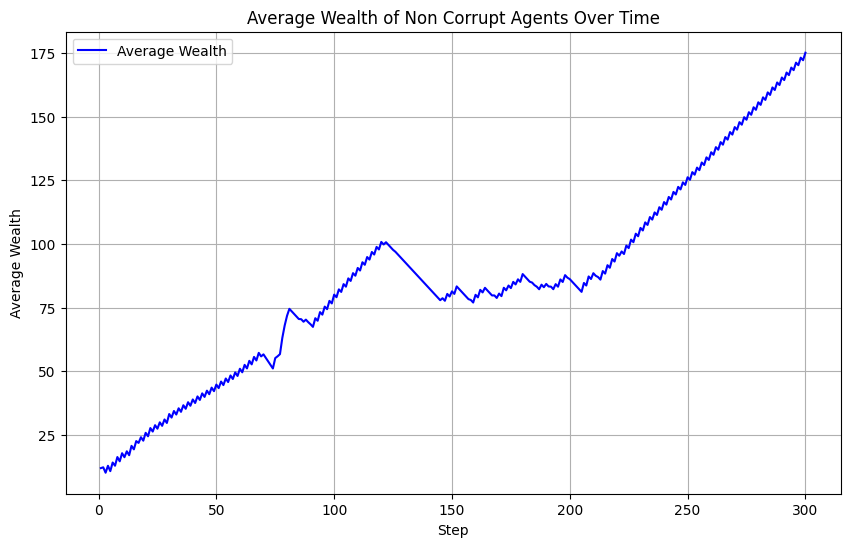

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Average Wealth"], label="Average Wealth", color="blue")
plt.xlabel("Step")
plt.ylabel("Average Wealth")
plt.title("Average Wealth of Non Corrupt Agents Over Time")
plt.legend()
plt.grid(True)
plt.savefig("/content/sample_data/nc_avg_wealth.png")
#plt.show()

Survival Rate

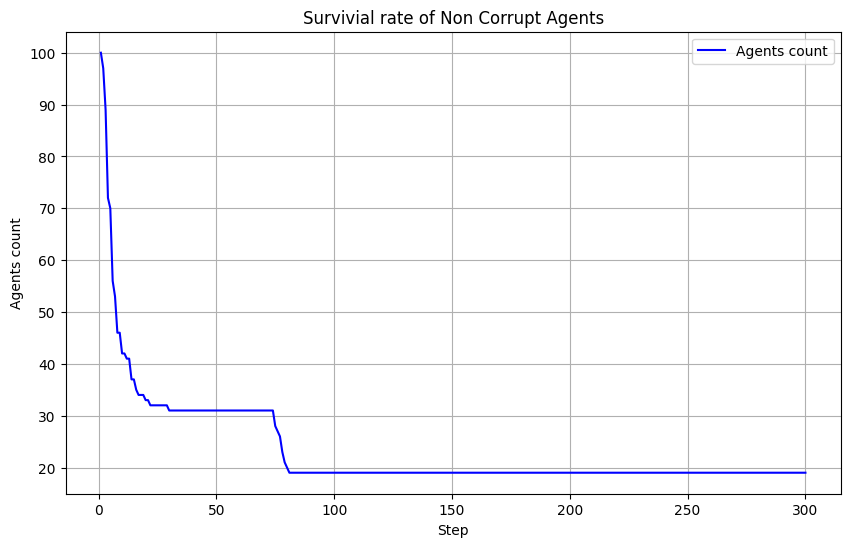

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(model_data["Step"], model_data["Agents"], label="Agents count", color="blue")
plt.xlabel("Step")
plt.ylabel("Agents count")
plt.title("Survivial rate of Non Corrupt Agents")
plt.legend()
plt.grid(True)
plt.savefig("/content/sample_data/nc_survival.png")
#plt.show()

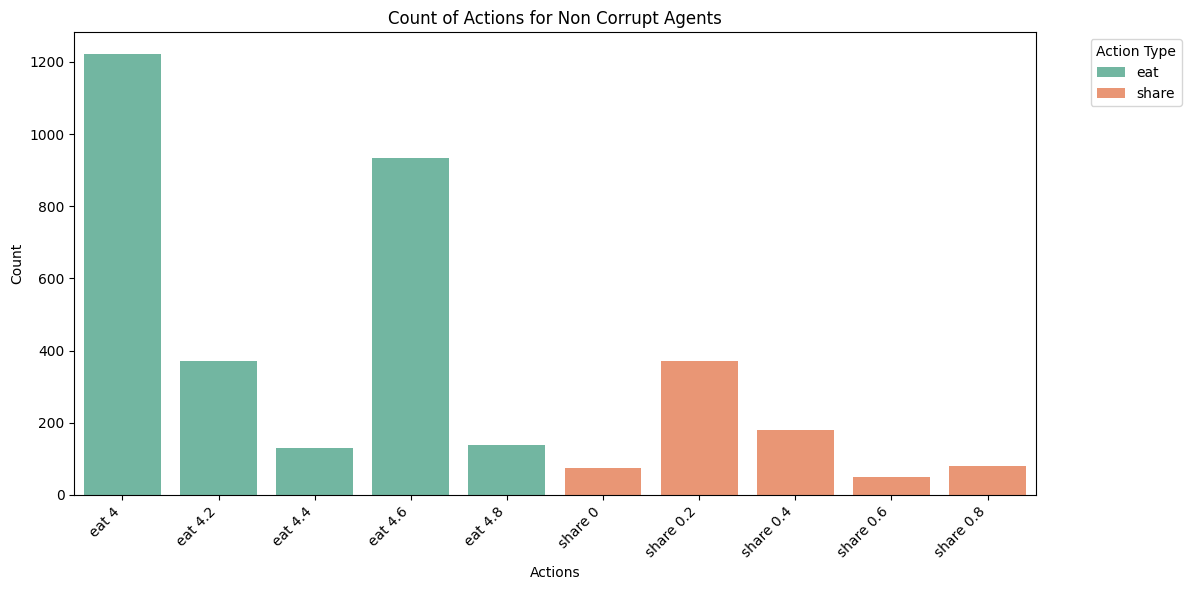

In [ ]:
data = []
for action, amounts in results.items():
    for amount, total in amounts.items():
        data.append({
            'action': f"{action} {amount}",
            'total': total,
            'action_type': action
        })

df = pd.DataFrame(data)
plt.figure(figsize=(12, 6))
sns.barplot(x='action', y='total', hue='action_type', data=df, palette='Set2')
plt.title('Count of Actions for Non Corrupt Agents')
plt.xticks(rotation=45, ha="right")
plt.xlabel('Actions')
plt.ylabel('Count')
plt.legend(title="Action Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("/content/sample_data/nc_actions.png")
#plt.show()

# Data collection

# Retrieve the data collected by the DataCollector
agent_data = model1.datacollector.get_agent_vars_dataframe()
mean_data = agent_data.groupby("Step").mean().reset_index()

#100th step data
step_100_data = agent_data.xs(100, level="Step")

#GroupBy bins in blocks of 100
bins = range(0, 210, 10)
step_100_data.loc[:, "Eaten Bins"] = pd.cut(step_100_data["Total Eaten"], bins=bins, right=False)
step_100_data.loc[:, "Shared Bins"] = pd.cut(step_100_data["Total Shared"], bins=bins, right=False)

grouped_eaten = step_100_data.groupby("Eaten Bins")["Wealth"].mean().reset_index()
grouped_shared = step_100_data.groupby("Shared Bins")["Wealth"].mean().reset_index()

# Extract Collection Efficiency and Wealth for step 100
collection_efficiency = agent_data["Collection Efficiency"]
wealth = agent_data["Wealth"]

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Collection Efficiency", y="Wealth")
plt.title('Collection Efficiency vs Wealth at Step 100')
plt.savefig("Plots/Non_corrupt/Wealth/efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=step_100_data, x="Consumption", y="Wealth")
plt.title('Consumption (Metabolism) vs Wealth at Step 100')
plt.savefig("Plots/Non_corrupt/Wealth/consumption.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Wealth")
plt.title('Wealth vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Non_corrupt/Wealth/toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Wealth")
plt.title('Wealth vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Mean Wealth')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Plots/Non_corrupt/Wealth/totshared.png")

agent_data.loc[:, "Eaten Bins"] = pd.cut(agent_data["Total Eaten"], bins=bins, right=False)
agent_data.loc[:, "Shared Bins"] = pd.cut(agent_data["Total Shared"], bins=bins, right=False)

grouped_eaten = agent_data.groupby("Eaten Bins")["Survival"].mean().reset_index()
grouped_shared = agent_data.groupby("Shared Bins")["Survival"].mean().reset_index()

# Collection Efficiency vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Collection Efficiency", y="Survival")
plt.title('Collection Efficiency vs Survival')
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_efficiency.png")

# Consumption vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=agent_data, x="Consumption", y="Survival")
plt.title('Consumption (Metabolism) vs Survival')
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_consumption.png")

#Total eat
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_eaten, x="Eaten Bins", y="Survival")
plt.title('Survival vs Total Eaten')
plt.xlabel('Total Eaten')
plt.ylabel('Survivial')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_toteaten.png")

# Total Shared vs Wealth
plt.figure(figsize=(10, 6))
sns.barplot(data=grouped_shared, x="Shared Bins", y="Survival")
plt.title('Survivla vs Total Shared')
plt.xlabel('Total Shared')
plt.ylabel('Survival')
plt.xticks(rotation=45)
plt.tight_layout()
#plt.show()
plt.savefig("Plots/Non_corrupt/Survival/corrupt_totshared.png")

In [ ]:
from mesa.visualization.UserParam import UserSettableParameter
# Portrayal function for visualization
def agent_portrayal(agent):
    portrayal = {"Shape": "circle",
                 "Filled": "true",
                 "r": 0.2}

    if isinstance(agent, Sugar):
        portrayal["Color"] = "green"
        portrayal["Layer"] = 0
        portrayal["r"] = agent.curr_amount / 30  # Scale size based on sugar amount
    elif isinstance(agent, Non_corrupt_agent):
        portrayal["Color"] = "blue"
        portrayal["Layer"] = 1
        #portrayal["r"] = agent.sugar_agent / 30  # Scale size based on agent's sugar
        portrayal["text"] = str(agent.sugar_agent)  # Display the unique_id as text
        portrayal["text_color"] = "black"  # Set the color of the text

    return portrayal

agent_count_element = AgentCountElement()
average_wealth_element = AverageWealthElement()

# CanvasGrid for visualization
grid = CanvasGrid(agent_portrayal, 50, 50, 500, 500)

# ChartModule for visualizing data
chart = ChartModule([{"Label": "Non_corrupt_agents",
                      "Color": "Red"},
                     {"Label": "Sugar",
                      "Color": "Green"}],
                    data_collector_name='datacollector')

# Setting up the server
server = ModularServer(Model,
                       [grid, agent_count_element, average_wealth_element],
                       "Sugar Model",
                       {"X": 50, "Y": 50, "init_population": 100, "init_resource_min": 25, "init_resource_max": 50,
                        "metabolism_min": 1, "metabolism_max": 5, "vision_min": 1, "vision_max": 5, "seed": global_seed})

# Launch the server
server.port = 8522  # The default
server.launch()

ImportError: cannot import name 'UserSettableParameter' from 'mesa.visualization.UserParam' (C:\Users\DELL\anaconda3\Lib\site-packages\mesa\visualization\UserParam.py)